In [1]:
import numpy as np
import pandas as pd

In [10]:
# Plots
import matplotlib.pyplot as plt
%matplotlib inline

In [102]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

import keras
import keras.optimizers as optimizers
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
import keras.backend as K

# Root Mean Squared Error
def root_mean_squared_error(y_true, y_pred):
        return np.abs(K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)))

In [82]:
data = pd.read_csv('~/Documents/Education/data_music.csv')

# Basic pre-processing

In [83]:
# Features / response split
X, y = data.drop(['genres'], axis = 1), data['genres']
X.index = X.track_id
X = X.drop(['track_id'], axis = 1)
X = X.select_dtypes(['number'])

In [107]:
hyperparameters = {
    'test_size': 0.4
}

def baseline_preprocessing(X, y, pca_k = None):
    """
    Baseline pre-processing.
    """
    # encode class values as integers
    encoder = LabelEncoder()
    y = encoder.fit_transform(y)
        
    # Train / test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = hyperparameters['test_size'])
    
    # To categorical
    dummy_y_train = np_utils.to_categorical(y_train)
    dummy_y_test = np_utils.to_categorical(y_test)

    # Standard Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if type(pca_k) == int:
        # Principal Component Analysis
        pca = PCA()
        X_pca_train = pca.fit_transform(X_train_scaled)
        X_pca_test = pca.transform(X_test_scaled)

        with plt.style.context('seaborn-whitegrid'):
            plt.figure(figsize=(16, 12))

            plt.bar(range(len(pca.components_)), pca.explained_variance_ratio_, alpha=0.5, align='center',
                    label='individual explained variance')
            plt.step(range(len(pca.components_)), np.cumsum(pca.explained_variance_ratio_), where='mid',
                     label='cumulative explained variance')
            plt.ylabel('Explained variance',fontweight="bold", fontsize=15)
            plt.xlabel('Principal components',fontweight="bold", fontsize=15)
            plt.title('Principal Components Analysis of core features', fontsize=18, color = "#35547a")
            plt.legend(loc = 'best', fontsize = 18)
            plt.tight_layout()
        return(X_pca_train[:,:pca_k], X_pca_test[:,:pca_k], y_train, y_test)

    return(X_train, X_test, y_train, y_test)

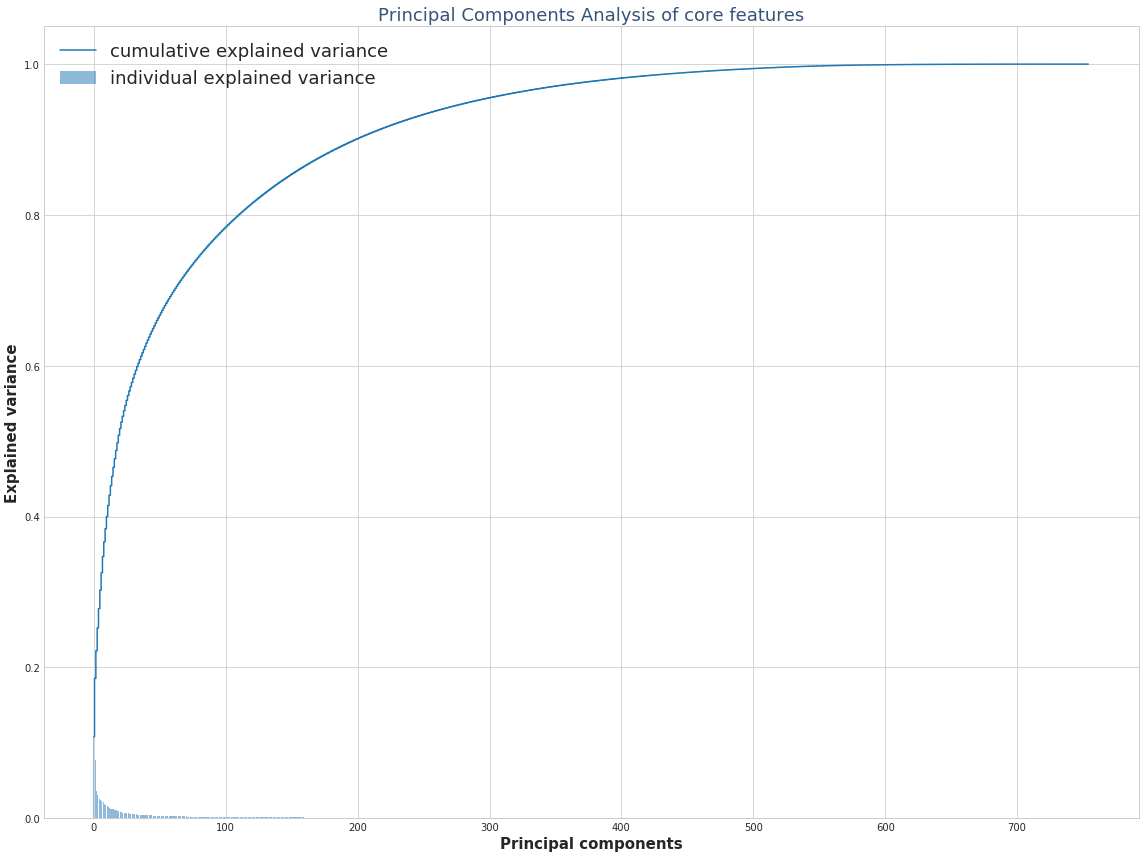

In [109]:
X_train, X_test, y_train, y_test = baseline_preprocessing(X, y, pca_k = 300)

In [110]:
class MLPModel:
    """
    This class encapsulates Deep Learning model (Multi-Layer perceptron)

    Parameters:
    - lr: learning rate
    - hidden: number of neurons in hidden layers
    - dropout: dropout rate
    - activation: activation function in the hidden layers
    - kernel_initializer: kernel initializer
    - regularizers: regularizers for the weight
    - decay; learning rate decay
    - momentum: momentum of the gradient descent
    - optimizer: optimizer used for gradient descent
    - batch_normalization: whether to add a BatchNormalization layer

    Attributes:
    - model: Keras Sequential instance

    Methods:
    - fit:
    - predict:
    """

    def __init__(self):
        pass

    def fit(self, X_train, X_test, y_train, y_test, callbacks = None, epochs = 20, batch_size = 32, iteration = 1, lr = 0.01, hidden = 20, dropout = 0., activation = 'relu',\
            kernel_initializer='Orthogonal', decay = 1e-5, momentum = 0.9, optimizer = 'adam', batch_normalization = True, activity_regularizer = None,\
            kernel_regularizer = None, bias_regularizer = None, loss = 'categorical_crossentropy'):

        # OPTIMIZERS
        if optimizer == 'adam':
            optimizer = optimizers.Adam(lr=lr, decay=decay)
        if optimizer == 'sgd':
            optimizer = optimizers.SGD(lr=lr, momentum=momentum, decay=decay, nesterov=False)
        if optimizer == 'rmsprop':
            rmsprop = optimizers.RMSprop(lr=lr, rho=0.9, epsilon=None, decay=decay)
        if optimizer == 'adadelta':
            optimizer = optimizers.Adadelta(lr=lr, rho=0.95, epsilon=None, decay=decay)

        # Create sequential model
        model = Sequential()

        # First layer (input)
        model.add(Dense(hidden, input_dim=X_train.shape[1]))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(Activation(activation))
        model.add(Dropout(dropout))

        # Second layer
        model.add(Dense(hidden))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(Activation(activation))
        model.add(Dropout(dropout))

        # Output layer
        model.add(Dense(14, activation = 'softmax'))

        # Compile model
        model.compile(loss = loss, optimizer=optimizer, metrics=['accuracy'])

        # Keras fit
        model.fit(X_train, y_train, nb_epoch = 20, batch_size = batch_size, shuffle = True, callbacks = callbacks, validation_data = (X_test, y_test))
       # Keras saving
        #self.model.save('mlp_'+str(iteration)+'.h5')
        return(self)

    def predict(self, test):
        predictions = pd.DataFrame(self.model.predict(test.drop(self.names, axis = 1)), columns = ['probability']).reset_index(drop = True)
        response = test[self.names].reset_index(drop = True)
        results = pd.concat((predictions, response), axis = 1)
        return(results)

    def transform(self):
        return(self.model)

In [111]:
mlp = MLPModel()
mlp.fit(np.asarray(X_train), np.asarray(X_test), dummy_y_train, dummy_y_test)

Train on 7877 samples, validate on 5252 samples
Epoch 1/20
7877/7877 [==============================] - 1s - loss: 2.0948 - acc: 0.3379 - val_loss: 2.0503 - val_acc: 0.3425
Epoch 2/20
7877/7877 [==============================] - 0s - loss: 2.0133 - acc: 0.3496 - val_loss: 2.0549 - val_acc: 0.3439
Epoch 3/20
7877/7877 [==============================] - 0s - loss: 1.9936 - acc: 0.3496 - val_loss: 2.0606 - val_acc: 0.3401
Epoch 4/20
7877/7877 [==============================] - 1s - loss: 1.9675 - acc: 0.3569 - val_loss: 2.0944 - val_acc: 0.3197
Epoch 5/20
7877/7877 [==============================] - 1s - loss: 1.9450 - acc: 0.3569 - val_loss: 2.1223 - val_acc: 0.3317
Epoch 6/20
7877/7877 [==============================] - 1s - loss: 1.9151 - acc: 0.3622 - val_loss: 2.1500 - val_acc: 0.3229
Epoch 7/20
7877/7877 [==============================] - 1s - loss: 1.8899 - acc: 0.3660 - val_loss: 2.1847 - val_acc: 0.3284
Epoch 8/20
7877/7877 [==============================] - 1s - loss: 1.8696 - a

<__main__.MLPModel instance at 0x1228d28c0>